In [1]:
# library import
import pandas as pd
import polars as pl
import numpy as np
from scipy.stats import ttest_rel
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import random
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


%matplotlib inline

import os
import re
import glob
import shutil
import gc
from pathlib import Path
import xlsxwriter

# showing module
from IPython.display import display

# output display option adjustment
# precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)

# precision of floating point in pandas
pd.options.display.float_format = '{:.4f}'.format

# display all columns in dataframe
pd.set_option("display.max_columns",None)

# default font size in graph
plt.rcParams["font.size"] = 14

# graph display
sns.set(rc={'figure.figsize':(12,5)})

# random seed
random_seed = 49

In [2]:
# create the input_dir（input directory）
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# if INPUT_DIR has not been created yet, create it
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) creation
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# if OUTPUT_DIR has not been created yet, create it
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [ ]:
# # Once you run this code, comment it out
# # move csv files to `data` directory(=folder)
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

In [3]:
# Polars function to let us read csv files without having to specify the directory
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pl.read_csv(path, **kwrgs)

In [20]:
df = read_csv('Prius_Prime_v2')
df.head()

Load: /Users/satoshiido/Documents/programming/statistical-analysis/582/Applied_MS_Exam/data/Prius_Prime_v2.csv


Date,overall_miles,overall_MPG,interval_miles,interval_MPG,interval_gallons,interval_days,interval_MPG_hand_calculated,overall_miles_lag,overall_miles_diff_lag,interval_gallons_lag,interval_gallons_diff_lag,interval_miles_lag,Year,Month,day_of_week,rol_avg_int_miles_2,rol_avg_int_gallons_2,gallons_ewm_3,miles_ewm_3,gallons_rol_std_3,miles_rol_std_3
str,i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64
"""2017-12-28""",1207,51.1,602.3,66.6,9.46,null,63.67,null,null,null,null,null,2017,12,4,602.3,9.46,9.46,602.3,0.0,0.0
"""2018-01-14""",1735,53.4,528.1,59.5,9.57,17,55.18,1207,-528,9.46,0.11,602.3,2018,1,7,565.2,9.515,9.533333,552.833333,0.077782,52.467323
"""2018-02-02""",2353,58.3,618.3,78.7,8.62,19,71.73,1735,-618,9.57,-0.95,528.1,2018,2,5,582.9,9.216667,9.011429,590.242857,0.599601,52.482514
"""2018-02-18""",2998,60.5,644.3,70.1,9.9,16,65.08,2353,-645,8.62,1.29,618.3,2018,2,7,598.25,9.3875,9.485333,619.073333,0.685496,48.46992
"""2018-03-03""",3587,61.0,588.7,63.6,9.91,13,59.4,2998,-589,9.9,0.01,644.3,2018,3,6,594.85,9.5,9.704516,603.396774,0.537679,38.124369


# Preprocessing

In [ ]:
# df = df.with_columns(
#         pl.col("Date").str.to_date("%Y-%m-%d").set_sorted()
#         ).with_columns(
#         pl.col("Date").dt.year().alias("Year"), 
#         pl.col("Date").dt.month().alias("Month")
#         )

# # calculate the rolling average of the 2 months
# ## sort the data by date and set the sorted index to date
# df = df.sort("Date").set_sorted("Date")

# df = df.with_columns(
#     day_of_week = pl.col("Date").dt.weekday().alias("weekday"),
#     # interval_miles_12mo_lag = pl.col("interval_miles").shift(12),
#     # interval_gallons_12mo_lag = pl.col("interval_gallons").shift(12),
#     # rolling average of miles over 2 months
#     rol_avg_int_miles_2 = pl.mean("interval_miles").rolling(index_column="Date", period="2mo"),
#     # rolling average of gallons over 2 months
#     rol_avg_int_gallons_2 = pl.mean("interval_gallons").rolling(index_column="Date", period="2mo"),
#     # exponentially weighted mean (EWMA) with a span of 3
#     gallons_ewm_3 = pl.col("interval_gallons").ewm_mean(span=3),
#     # exponentially weighted mean (EWMA) with a span of 3
#     miles_ewm_3 = pl.col("interval_miles").ewm_mean(span=3),
#     # exponentially weighted standard deviation (EWSD) with a span of 3
#     gallons_rol_std_3 = pl.col("interval_gallons").ewm_std(span=3),
#     # exponentially weighted standard deviation (EWSD) with a span of 3
#     miles_rol_std_3 = pl.col("interval_miles").ewm_std(span=3)
# )
# df.head()
# df.write_csv(os.path.join(INPUT_DIR, "Prius_Prime_v2.csv"))
# df.write_excel(os.path.join(OUTPUT_DIR, "Prius_Prime_v2.xlsx"))

In [21]:
df = df.with_columns(
        pl.col("Date").str.to_date("%Y-%m-%d").set_sorted()
    )

df2 = df[1:]

df2 = df2.with_columns(
    interval_mpg_diff = pl.col("interval_MPG") - pl.col("interval_MPG_hand_calculated")
)

In [45]:
## sort the data by date and set the sorted index to date
df2 = df2.sort("Date").set_sorted("Date")
df2 = df2.with_columns(
    # interval mpg mean
    rol_avg_int_mpg_2 = pl.mean("interval_MPG_hand_calculated").rolling(index_column="Date", period="2mo"),
    int_mpg_ewm_3 = pl.col("interval_MPG_hand_calculated").ewm_mean(span=3),
    int_mpg_std_3 = pl.col("interval_MPG_hand_calculated").ewm_std(span=3),
    # interval mpg diff mean
    rol_avg_int_mpg_diff_2 = pl.mean("interval_mpg_diff").rolling(index_column="Date", period="2mo"),
    int_mpg_diff_ewm_3 = pl.col("interval_mpg_diff").ewm_mean(span=3),
    int_mpg_diff_std_3 = pl.col("interval_mpg_diff").ewm_std(span=3)
)

In [46]:
# calculate an average of each col by year
df2_by_year = df2.group_by("Year").agg(
    pl.col("interval_miles").count().alias("count_interval_miles"),
    pl.col("interval_days").mean().alias("avg_interval_days"),
    # interval miles
    pl.col("interval_miles").mean().alias("avg_interval_miles"),
    pl.col("rol_avg_int_miles_2").mean().alias("rol_avg_int_miles_2"),
    pl.col("miles_ewm_3").mean().alias("miles_ewm_3"),
    pl.col("miles_rol_std_3").mean().alias("miles_rol_std_3"),
    # interval gallons
    pl.col("interval_gallons").mean().alias("avg_interval_gallons"),
    pl.col("rol_avg_int_gallons_2").mean().alias("rol_avg_int_gallons_2"),
    pl.col("gallons_ewm_3").mean().alias("gallons_ewm_3"),
    pl.col("gallons_rol_std_3").mean().alias("gallons_rol_std_3"),
    # interval MPG
    pl.col("interval_MPG").mean().alias("avg_interval_MPG"),
    pl.col("rol_avg_int_mpg_2").mean().alias("rol_avg_int_mpg_2"),
    pl.col("int_mpg_ewm_3").mean().alias("int_mpg_ewm_3"),
    pl.col("int_mpg_std_3").mean().alias("int_mpg_std_3"),
    # interval MPG diff
    pl.col("interval_mpg_diff").mean().alias("avg_interval_mpg_diff"),
    pl.col("rol_avg_int_mpg_diff_2").mean().alias("rol_avg_int_mpg_diff_2"),
    pl.col("int_mpg_diff_ewm_3").mean().alias("int_mpg_diff_ewm_3"),
    pl.col("int_mpg_diff_std_3").mean().alias("int_mpg_diff_std_3")
)
df2_by_year

Year,count_interval_miles,avg_interval_days,avg_interval_miles,rol_avg_int_miles_2,miles_ewm_3,miles_rol_std_3,avg_interval_gallons,rol_avg_int_gallons_2,gallons_ewm_3,gallons_rol_std_3,avg_interval_MPG,rol_avg_int_mpg_2,int_mpg_ewm_3,int_mpg_std_3,avg_interval_mpg_diff,rol_avg_int_mpg_diff_2,int_mpg_diff_ewm_3,int_mpg_diff_std_3
i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020,4,20.75,452.575,496.8375,493.062797,132.307308,8.1625,8.192917,8.246962,0.93545,60.05,60.0425,59.377186,11.781036,4.715,5.0325,4.869644,1.486355
2022,24,15.625,565.4,595.237654,566.488743,173.08633,8.15,8.182867,8.192621,0.971356,73.979167,72.341889,68.938421,16.549214,4.646667,4.669519,4.582418,1.649091
2024,7,12.571429,424.985714,534.69915,484.712423,256.73353,7.025714,7.000269,7.18998,1.815652,62.971429,73.216908,64.876276,24.78076,4.598571,5.414248,4.965347,1.532618
2019,17,21.411765,634.576471,661.61098,638.205229,176.241729,8.434706,8.310373,8.355935,1.066716,80.011765,79.099294,76.012444,18.271061,5.004118,5.383745,5.033003,1.996875
2023,19,18.526316,584.194737,639.977686,566.528346,223.832018,7.591053,7.433639,7.498956,1.416979,79.731579,83.786568,74.161578,21.164769,4.205263,5.050901,4.185743,2.4468
2021,15,42.6,670.066667,720.723635,663.777243,231.77086,8.651333,8.809975,8.714627,0.579149,81.473333,81.599137,75.73702,24.39718,4.548667,4.630848,4.545267,1.834297
2018,15,24.533333,654.993333,719.127,649.598515,283.854812,7.936,8.261433,8.069176,1.35863,86.06,85.6028,78.85077,27.124522,5.484,5.946089,5.45631,2.820585


In [47]:
# calculate an average of each col by month
df2_by_month = df2.group_by("Month").agg(
    pl.col("interval_miles").count().alias("count_interval_miles"),
    pl.col("interval_days").mean().alias("avg_interval_days"),
    # interval miles
    pl.col("interval_miles").mean().alias("avg_interval_miles"),
    pl.col("rol_avg_int_miles_2").mean().alias("rol_avg_int_miles_2"),
    pl.col("miles_ewm_3").mean().alias("miles_ewm_3"),
    pl.col("miles_rol_std_3").mean().alias("miles_rol_std_3"),
    # interval gallons
    pl.col("interval_gallons").mean().alias("avg_interval_gallons"),
    pl.col("rol_avg_int_gallons_2").mean().alias("rol_avg_int_gallons_2"),
    pl.col("gallons_ewm_3").mean().alias("gallons_ewm_3"),
    pl.col("gallons_rol_std_3").mean().alias("gallons_rol_std_3"),
    # interval MPG
    pl.col("interval_MPG").mean().alias("avg_interval_MPG"),
    pl.col("rol_avg_int_mpg_2").mean().alias("rol_avg_int_mpg_2"),
    pl.col("int_mpg_ewm_3").mean().alias("int_mpg_ewm_3"),
    pl.col("int_mpg_std_3").mean().alias("int_mpg_std_3"),
    # interval MPG diff
    pl.col("interval_mpg_diff").mean().alias("avg_interval_mpg_diff"),
    pl.col("rol_avg_int_mpg_diff_2").mean().alias("rol_avg_int_mpg_diff_2"),
    pl.col("int_mpg_diff_ewm_3").mean().alias("int_mpg_diff_ewm_3"),
    pl.col("int_mpg_diff_std_3").mean().alias("int_mpg_diff_std_3")
)
df2_by_month

Month,count_interval_miles,avg_interval_days,avg_interval_miles,rol_avg_int_miles_2,miles_ewm_3,miles_rol_std_3,avg_interval_gallons,rol_avg_int_gallons_2,gallons_ewm_3,gallons_rol_std_3,avg_interval_MPG,rol_avg_int_mpg_2,int_mpg_ewm_3,int_mpg_std_3,avg_interval_mpg_diff,rol_avg_int_mpg_diff_2,int_mpg_diff_ewm_3,int_mpg_diff_std_3
i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,12,34.083333,530.591667,653.604028,565.819946,252.024554,7.794167,7.782694,7.795733,1.018309,70.766667,81.640917,70.415498,26.997949,5.303333,5.736583,5.271485,1.506137
2,6,29.333333,642.266667,593.147222,603.248075,161.396763,8.468333,8.357917,8.39818,1.023942,81.55,70.949722,71.565623,15.937438,6.235,5.728056,5.869991,1.65631
5,6,41.5,736.05,786.759167,689.310988,262.495175,8.62,8.609417,8.461416,0.935905,90.783333,90.896583,80.762074,27.52774,5.863333,7.205917,5.67687,3.078677
4,5,9.4,543.56,589.563333,562.158761,126.460723,8.774,8.4784,8.549166,0.791475,66.16,69.5358,65.761702,14.393332,4.196,5.193533,4.776737,1.911901
9,7,23.428571,715.071429,577.227381,650.048121,195.983817,8.898571,8.088759,8.624053,1.015496,84.342857,69.971675,74.606751,16.974095,4.551429,3.908172,4.338488,1.600658
12,8,28.0,620.825,702.814583,631.385628,251.505217,7.6025,7.657083,7.754351,1.092948,87.35,90.314167,80.698496,27.205601,5.33125,5.603542,5.067695,2.254633
7,15,15.133333,613.88,672.129833,591.58737,178.144649,8.358667,8.409013,8.2831,1.231327,77.066667,79.569257,71.271243,15.745661,3.711333,4.552775,3.721275,1.995715
11,6,34.666667,676.45,778.515278,675.611761,304.482718,7.383333,7.978472,7.728042,1.079975,92.7,94.495556,84.601665,30.348667,5.616667,5.803056,5.467671,2.989169
3,13,18.153846,522.315385,556.428645,530.330866,187.522381,8.136923,8.120645,8.125571,1.485945,68.2,67.401489,64.390341,16.604915,4.6,5.164134,4.858484,1.457475


In [48]:
# calculate an average of each col by day of week
df2_by_day_of_week = df2.group_by("day_of_week").agg(
    pl.col("interval_miles").count().alias("count_interval_miles"),
    pl.col("interval_days").mean().alias("avg_interval_days"),
    # interval miles
    pl.col("interval_miles").mean().alias("avg_interval_miles"),
    pl.col("rol_avg_int_miles_2").mean().alias("rol_avg_int_miles_2"),
    pl.col("miles_ewm_3").mean().alias("miles_ewm_3"),
    pl.col("miles_rol_std_3").mean().alias("miles_rol_std_3"),
    # interval gallons
    pl.col("interval_gallons").mean().alias("avg_interval_gallons"),
    pl.col("rol_avg_int_gallons_2").mean().alias("rol_avg_int_gallons_2"),
    pl.col("gallons_ewm_3").mean().alias("gallons_ewm_3"),
    pl.col("gallons_rol_std_3").mean().alias("gallons_rol_std_3"),
    # interval MPG
    pl.col("interval_MPG").mean().alias("avg_interval_MPG"),
    pl.col("rol_avg_int_mpg_2").mean().alias("rol_avg_int_mpg_2"),
    pl.col("int_mpg_ewm_3").mean().alias("int_mpg_ewm_3"),
    pl.col("int_mpg_std_3").mean().alias("int_mpg_std_3"),
    # interval MPG diff
    pl.col("interval_mpg_diff").mean().alias("avg_interval_mpg_diff"),
    pl.col("rol_avg_int_mpg_diff_2").mean().alias("rol_avg_int_mpg_diff_2"),
    pl.col("int_mpg_diff_ewm_3").mean().alias("int_mpg_diff_ewm_3"),
    pl.col("int_mpg_diff_std_3").mean().alias("int_mpg_diff_std_3")
)
df2_by_day_of_week

day_of_week,count_interval_miles,avg_interval_days,avg_interval_miles,rol_avg_int_miles_2,miles_ewm_3,miles_rol_std_3,avg_interval_gallons,rol_avg_int_gallons_2,gallons_ewm_3,gallons_rol_std_3,avg_interval_MPG,rol_avg_int_mpg_2,int_mpg_ewm_3,int_mpg_std_3,avg_interval_mpg_diff,rol_avg_int_mpg_diff_2,int_mpg_diff_ewm_3,int_mpg_diff_std_3
i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,6,20.166667,700.15,714.512778,649.477756,223.452169,7.858333,8.228944,8.080664,1.210572,91.283333,85.750139,79.211843,22.390107,5.188333,4.923194,4.7471,1.610826
6,19,35.631579,576.752632,599.345439,570.659291,188.020582,7.815263,7.77812,7.812974,1.198779,77.773684,75.923698,72.133392,17.213002,4.821053,5.076452,4.778698,1.878184
4,15,24.266667,640.2,677.579627,653.037363,233.504888,8.806,8.445511,8.548177,0.935556,77.153333,79.487238,75.75488,23.509796,4.992667,5.038587,4.955012,2.06166
1,13,30.538462,676.3,712.733297,625.460988,254.333041,7.823077,8.04274,7.969862,1.115255,89.492308,87.578183,77.342371,26.933028,4.970769,5.395388,4.865013,2.089277
5,22,12.954545,546.75,595.467141,561.827014,188.566877,8.105,7.93081,8.003079,1.255131,71.386364,73.936606,69.378095,18.044055,4.641818,4.677247,4.49606,1.878899
7,20,11.25,500.735,601.864196,554.321221,196.478557,7.822,8.15491,8.101391,1.114322,67.18,72.923708,67.590496,18.880006,3.665,4.934149,4.418915,2.087311
3,6,33.333333,753.483333,796.540278,693.761124,277.281552,8.28,8.462778,8.228631,0.902699,97.4,93.433333,83.425935,27.433575,6.728333,7.158333,5.864671,3.332218


# Plotting

Plot the Targeted Response Variable `interval_mileage`, `Overall Mileage`, `Interval MPG`, and `Interval MPG Difference` to see the distribution of the data.

Text(0.5, 0, 'Interval Miles')

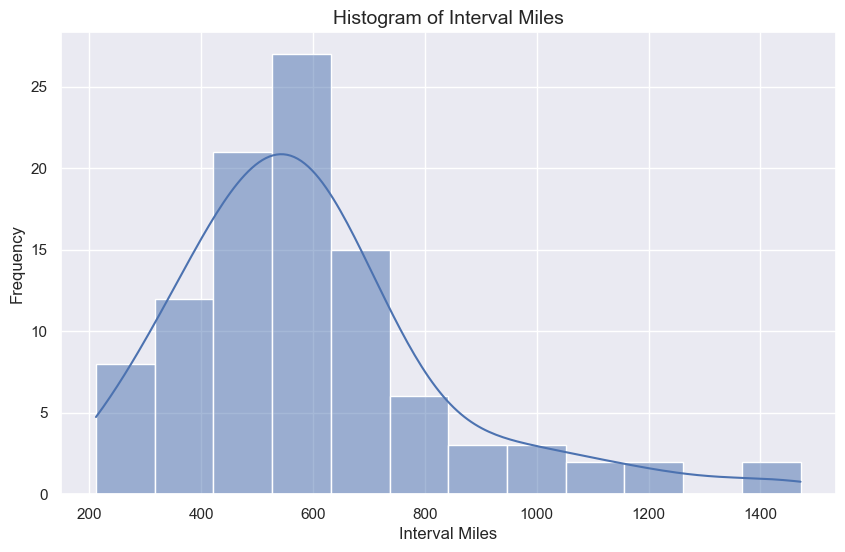

In [49]:
# Histogram of `interval_mileage`
plt.figure(figsize=(10, 6))
sns.histplot(data=df2, x="interval_miles", kde=True).set_title("Histogram of Interval Miles", fontsize = 14)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Interval Miles', fontsize = 12)

Text(0.5, 0, 'Interval Gallons')

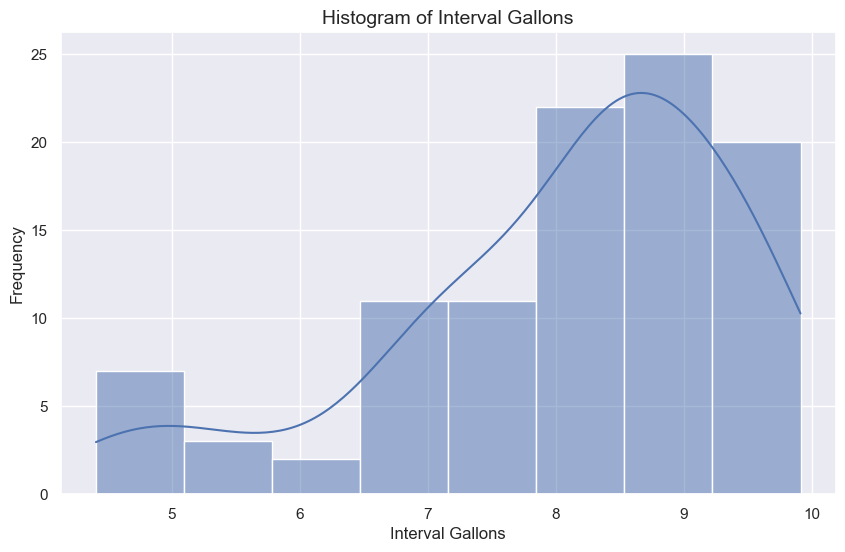

In [50]:
# Histogram of `interval_mileage`
plt.figure(figsize=(10, 6))
sns.histplot(data=df2, x="interval_gallons", kde=True).set_title("Histogram of Interval Gallons", fontsize = 14)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Interval Gallons', fontsize = 12)

Text(0.5, 0, 'Interval MPG')

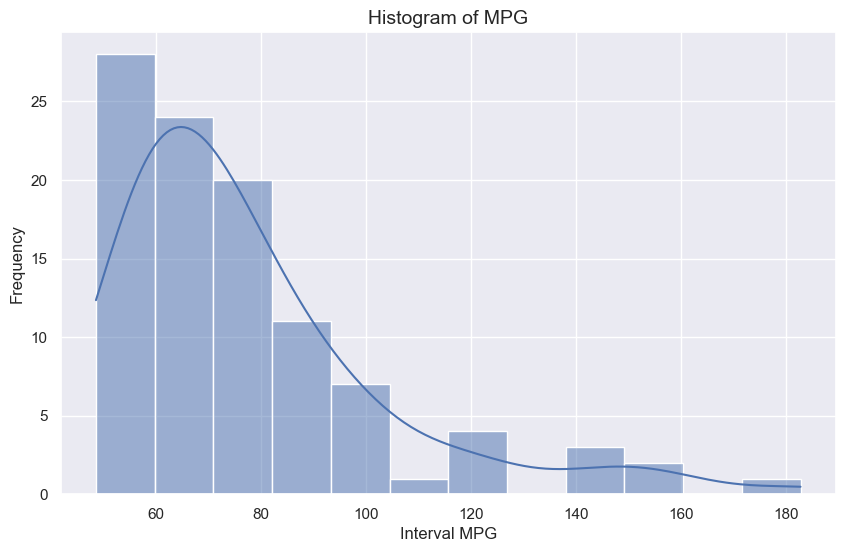

In [51]:
# Histogram of `interval_MPG`
plt.figure(figsize=(10, 6))
sns.histplot(data=df2, x="interval_MPG", kde=True).set_title("Histogram of MPG", fontsize = 14)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Interval MPG', fontsize = 12)
# Shapiro-Wilk test for normality
# stats.shapiro(df2["interval_MPG"])

ShapiroResult(statistic=0.919157087802887, pvalue=1.1584713320189621e-05)

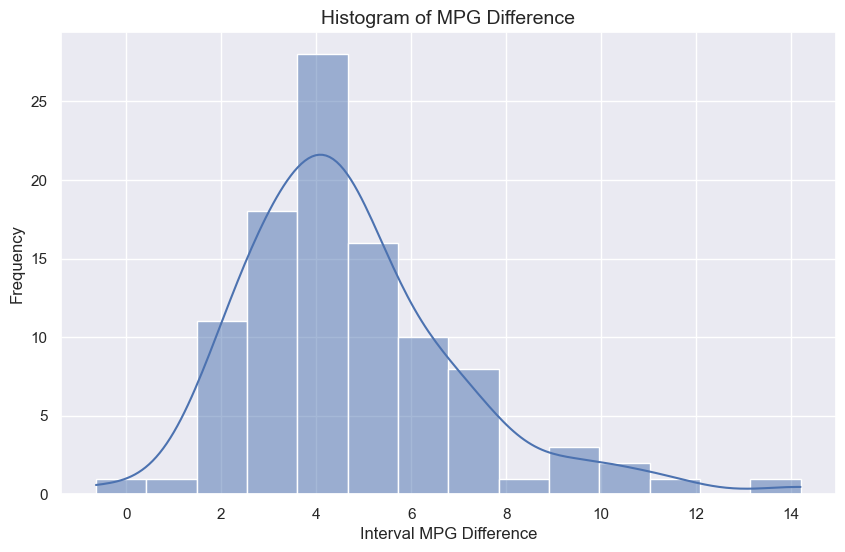

In [52]:
# Histogram of `interval_mileage`
plt.figure(figsize=(10, 6))
sns.histplot(data=df2, x="interval_mpg_diff", kde=True).set_title("Histogram of MPG Difference", fontsize = 14)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Interval MPG Difference', fontsize = 12)
# Shapiro-Wilk test for normality
stats.shapiro(df2["interval_mpg_diff"])


Text(0.5, 1.0, 'Overall Mileage Changes from 2018-2024')

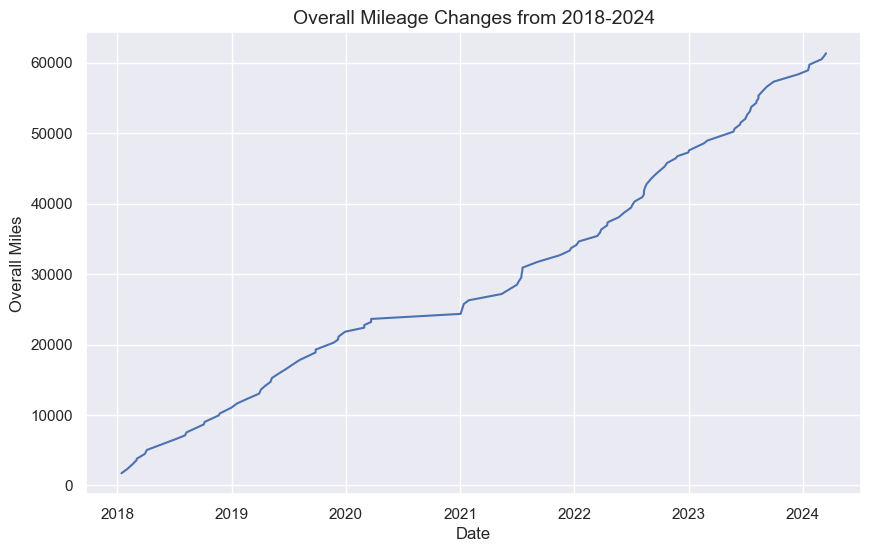

In [53]:
# Lineplot of `interval_MPG`
plt.figure(figsize=(10, 6))
# sort the data by year
df2 = df2.sort("Date")
plt.plot(df2["Date"], df2["overall_miles"], label="Overall Miles")
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Overall Miles', fontsize = 12)
plt.title('Overall Mileage Changes from 2018-2024', fontsize = 14)

### Year
Interval Oil Consumption, Interval Mileage, and Interval MPG difference by year

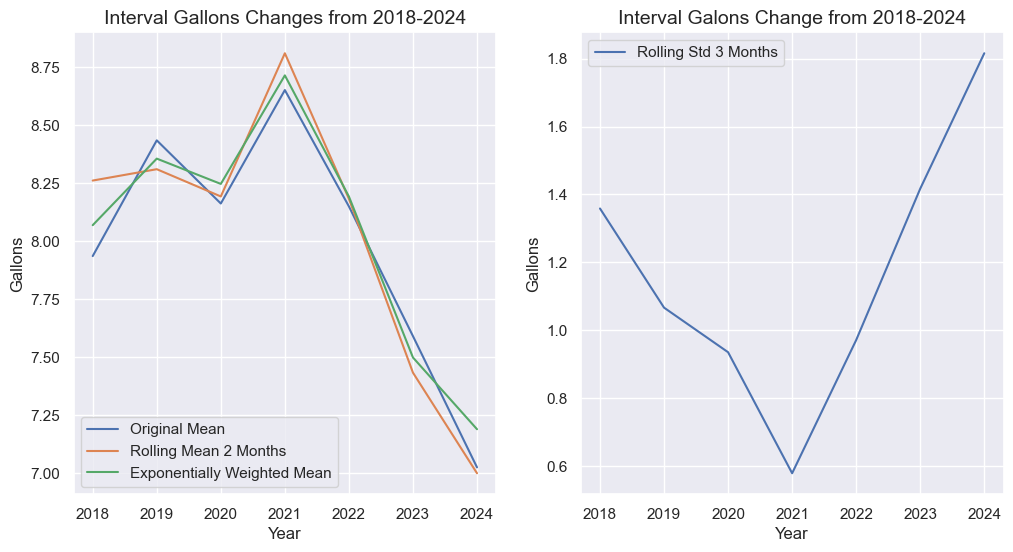

In [54]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# fig, ax1 = plt.subplots(figsize=(6, 6))

# sort the data by year
df2_by_year = df2_by_year.sort("Year")

# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_year["Year"], df2_by_year["avg_interval_gallons"], label="Original Mean")
ax1.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_gallons_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_year["Year"], df2_by_year["gallons_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Gallons Changes from 2018-2024", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("Gallons", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_year["Year"], df2_by_year["gallons_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Galons Change from 2018-2024", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("Gallons", fontsize = 12)
ax2.legend()

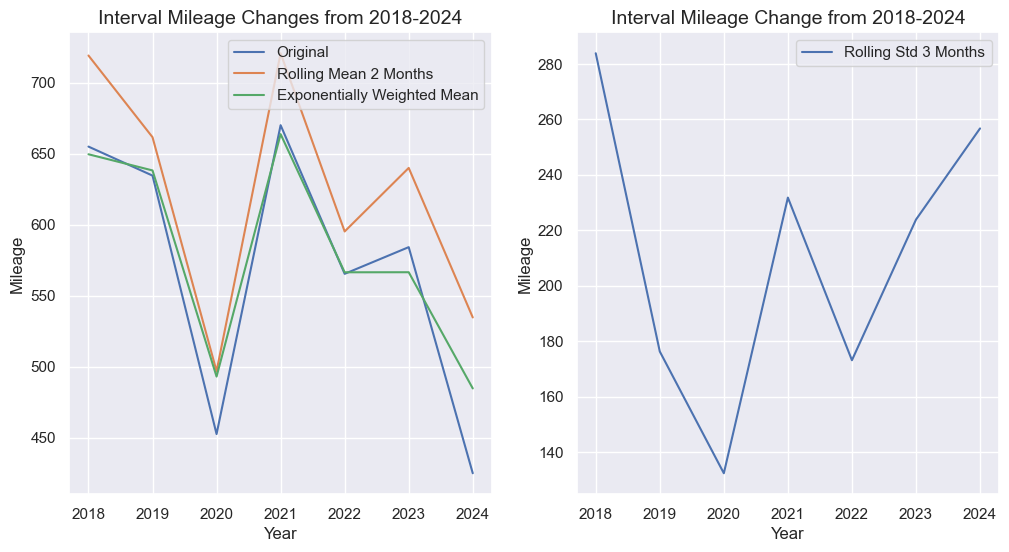

In [55]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_year = df2_by_year.sort("Year")

# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_year["Year"], df2_by_year["avg_interval_miles"], label="Original")
ax1.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_miles_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_year["Year"], df2_by_year["miles_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Mileage Changes from 2018-2024", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("Mileage", fontsize = 12)
ax1.legend() 

# temperature graph with rolling std
ax2.plot(df2_by_year["Year"], df2_by_year["miles_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Mileage Change from 2018-2024", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("Mileage", fontsize = 12)
ax2.legend()

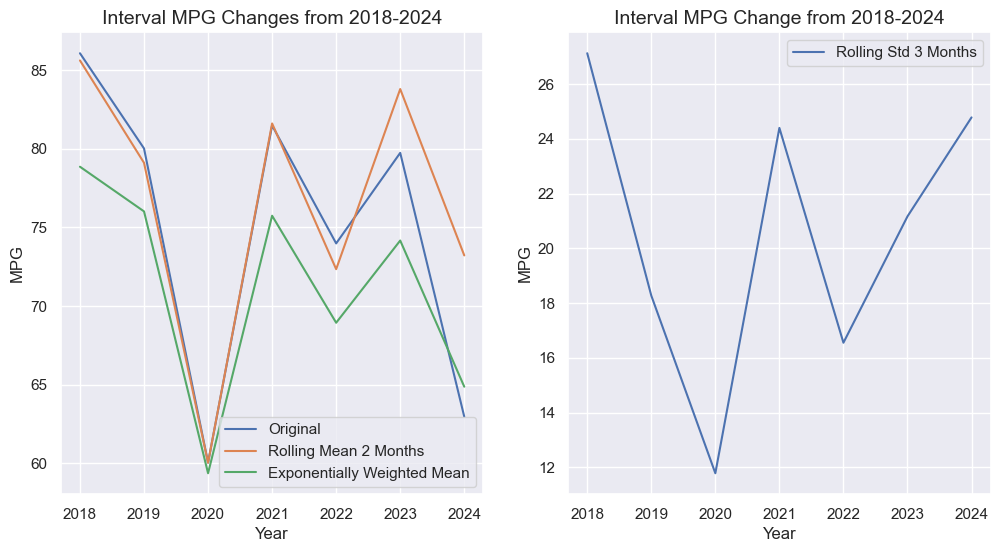

In [56]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_year = df2_by_year.sort("Year")

# MPG graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_year["Year"], df2_by_year["avg_interval_MPG"], label="Original")
ax1.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_mpg_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_year["Year"], df2_by_year["int_mpg_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval MPG Changes from 2018-2024", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("MPG", fontsize = 12)
ax1.legend()

# MPG graph with rolling std
ax2.plot(df2_by_year["Year"], df2_by_year["int_mpg_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval MPG Change from 2018-2024", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("MPG", fontsize = 12)
ax2.legend()


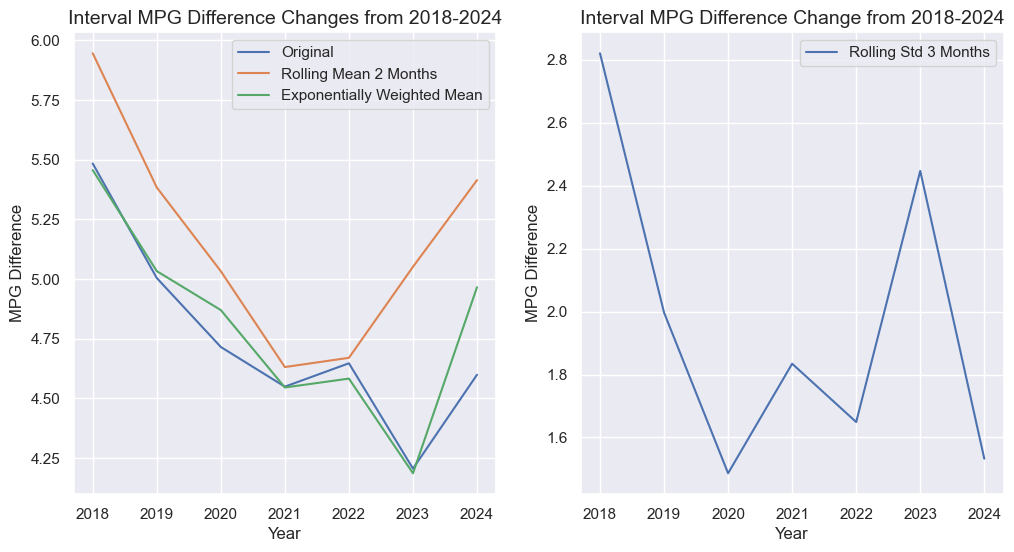

In [57]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_year = df2_by_year.sort("Year")

# MPG difference graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_year["Year"], df2_by_year["avg_interval_mpg_diff"], label="Original")
ax1.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_mpg_diff_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_year["Year"], df2_by_year["int_mpg_diff_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval MPG Difference Changes from 2018-2024", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("MPG Difference", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_year["Year"], df2_by_year["int_mpg_diff_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval MPG Difference Change from 2018-2024", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("MPG Difference", fontsize = 12)
ax2.legend()

For the report

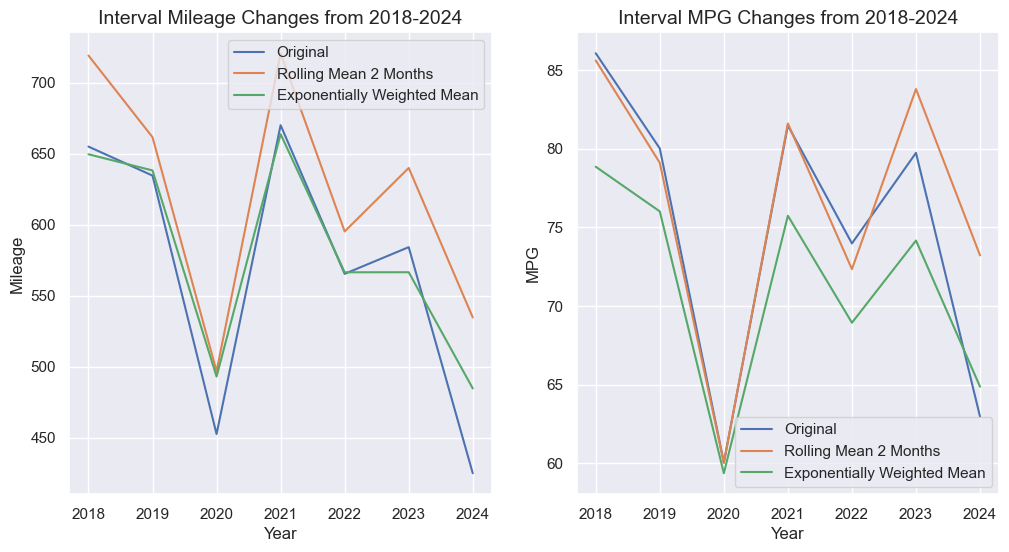

In [65]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_year = df2_by_year.sort("Year")

# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_year["Year"], df2_by_year["avg_interval_miles"], label="Original")
ax1.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_miles_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_year["Year"], df2_by_year["miles_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Mileage Changes from 2018-2024", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("Mileage", fontsize = 12)
ax1.legend() 

# MPG graph with rolling mean and exponentially weighted moving mean
ax2.plot(df2_by_year["Year"], df2_by_year["avg_interval_MPG"], label="Original")
ax2.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_mpg_2"], label="Rolling Mean 2 Months")
ax2.plot(df2_by_year["Year"], df2_by_year["int_mpg_ewm_3"], label="Exponentially Weighted Mean")
ax2.set_title("Interval MPG Changes from 2018-2024", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("MPG", fontsize = 12)
ax2.legend()

### Month
Interval Mileage and Oil Consumption by month

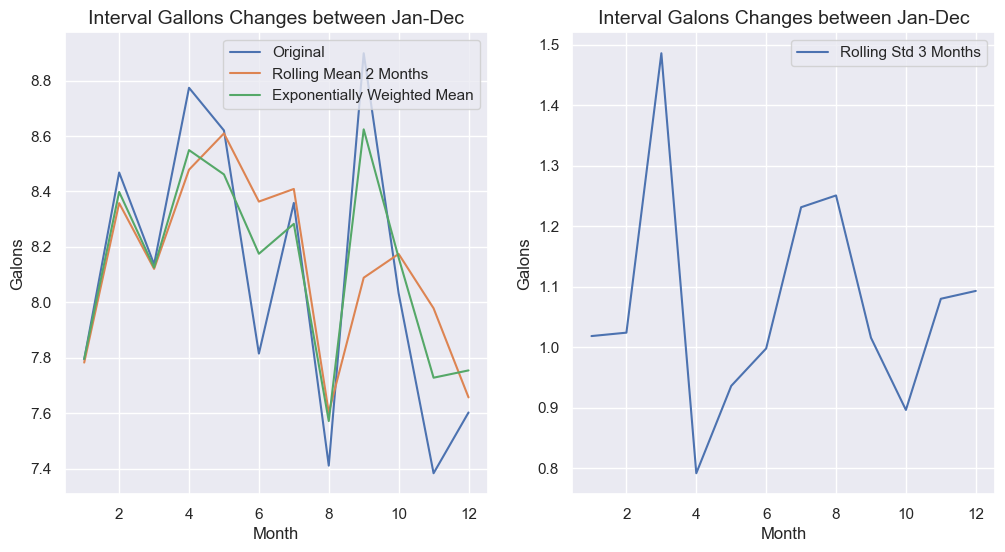

In [58]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_month = df2_by_month.sort("Month")

# interval gallons graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_gallons"], label="Original")
ax1.plot(df2_by_month["Month"], df2_by_month["rol_avg_int_gallons_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_month["Month"], df2_by_month["gallons_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Gallons Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Galons", fontsize = 12)
ax1.legend()

# interval gallons graph with rolling std
ax2.plot(df2_by_month["Month"], df2_by_month["gallons_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Galons Changes between Jan-Dec", fontsize = 14)
ax2.set_xlabel("Month", fontsize = 12)
ax2.set_ylabel("Galons", fontsize = 12)
ax2.legend()

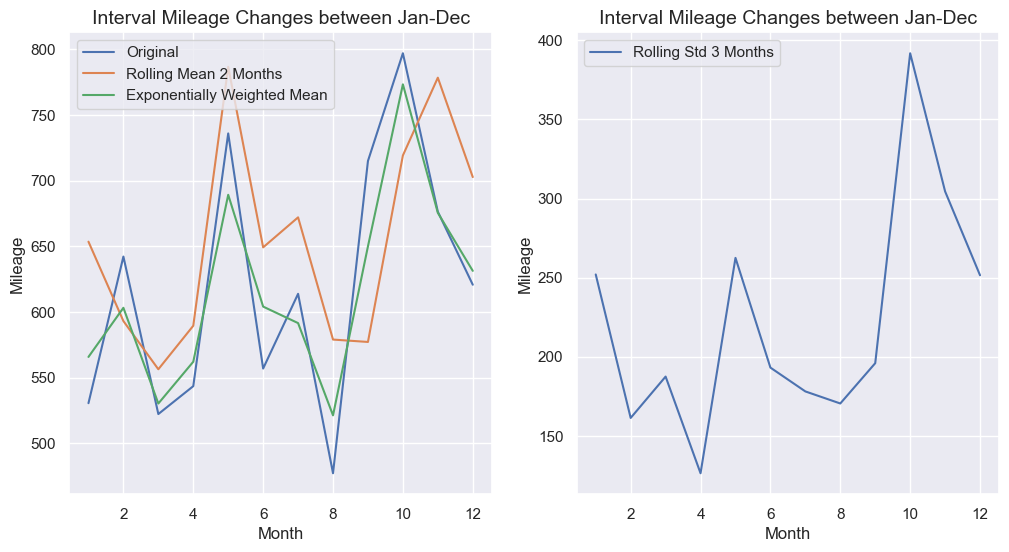

In [59]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_month = df2_by_month.sort("Month")

# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_miles"], label="Original")
ax1.plot(df2_by_month["Month"], df2_by_month["rol_avg_int_miles_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_month["Month"], df2_by_month["miles_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Mileage Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Mileage", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_month["Month"], df2_by_month["miles_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Mileage Changes between Jan-Dec", fontsize = 14)
ax2.set_xlabel("Month", fontsize = 12)
ax2.set_ylabel("Mileage", fontsize = 12)
ax2.legend()

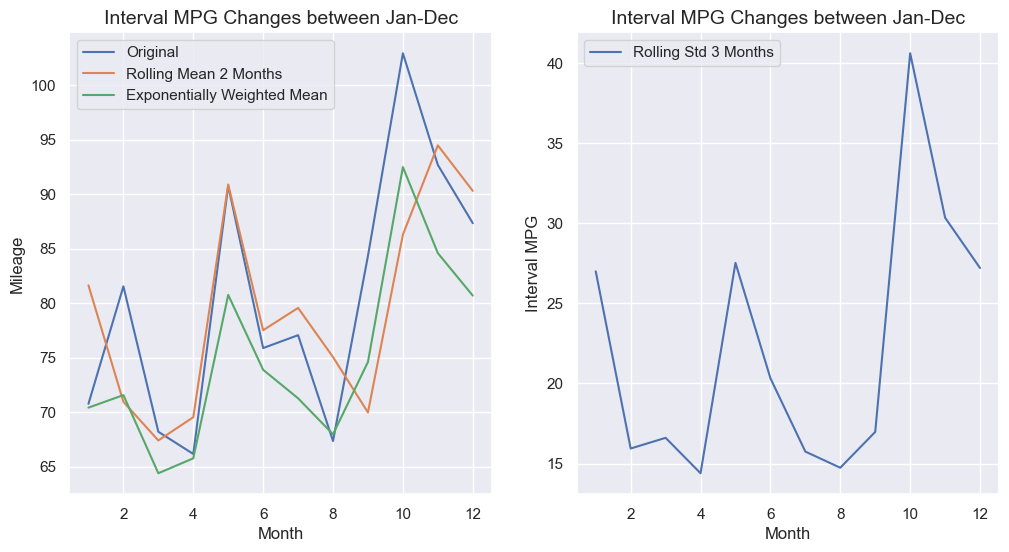

In [60]:
# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_mpg_diff"], label="Original")
ax1.set_title("Interval MPG Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Interval MPG", fontsize = 12)

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_month = df2_by_month.sort("Month")

# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_MPG"], label="Original")
ax1.plot(df2_by_month["Month"], df2_by_month["rol_avg_int_mpg_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_month["Month"], df2_by_month["int_mpg_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval MPG Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Mileage", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_month["Month"], df2_by_month["int_mpg_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval MPG Changes between Jan-Dec", fontsize = 14)
ax2.set_xlabel("Month", fontsize = 12)
ax2.set_ylabel("Interval MPG", fontsize = 12)
ax2.legend()

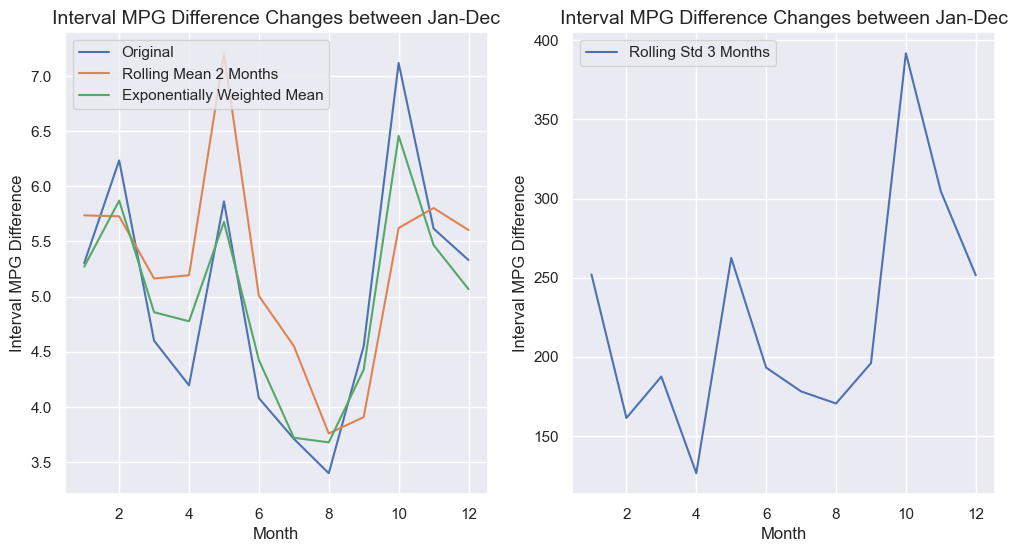

In [61]:
# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_mpg_diff"], label="Original")
ax1.set_title("Interval MPG Difference Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Interval MPG Difference", fontsize = 12)

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_month = df2_by_month.sort("Month")

# temperature graph with rolling mean and exponentially weighted moving mean
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_mpg_diff"], label="Original")
ax1.plot(df2_by_month["Month"], df2_by_month["rol_avg_int_mpg_diff_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_month["Month"], df2_by_month["int_mpg_diff_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval MPG Difference Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Interval MPG Difference", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_month["Month"], df2_by_month["miles_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval MPG Difference Changes between Jan-Dec", fontsize = 14)
ax2.set_xlabel("Month", fontsize = 12)
ax2.set_ylabel("Interval MPG Difference", fontsize = 12)
ax2.legend()

### Day of Week
Interval Mileage and Oil Consumption by day of week

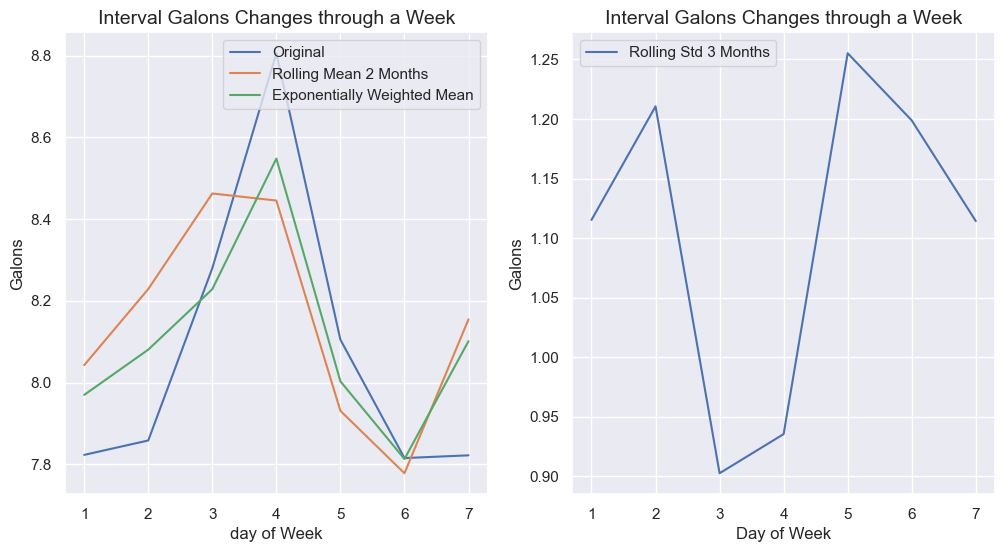

In [62]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_day_of_week = df2_by_day_of_week.sort("day_of_week")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["avg_interval_gallons"], label="Original")
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["rol_avg_int_gallons_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["gallons_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Galons Changes through a Week", fontsize = 14)
ax1.set_xlabel("day of Week", fontsize = 12)
ax1.set_ylabel("Galons", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["gallons_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Galons Changes through a Week", fontsize = 14)
ax2.set_xlabel("Day of Week", fontsize = 12)
ax2.set_ylabel("Galons", fontsize = 12)
ax2.legend()

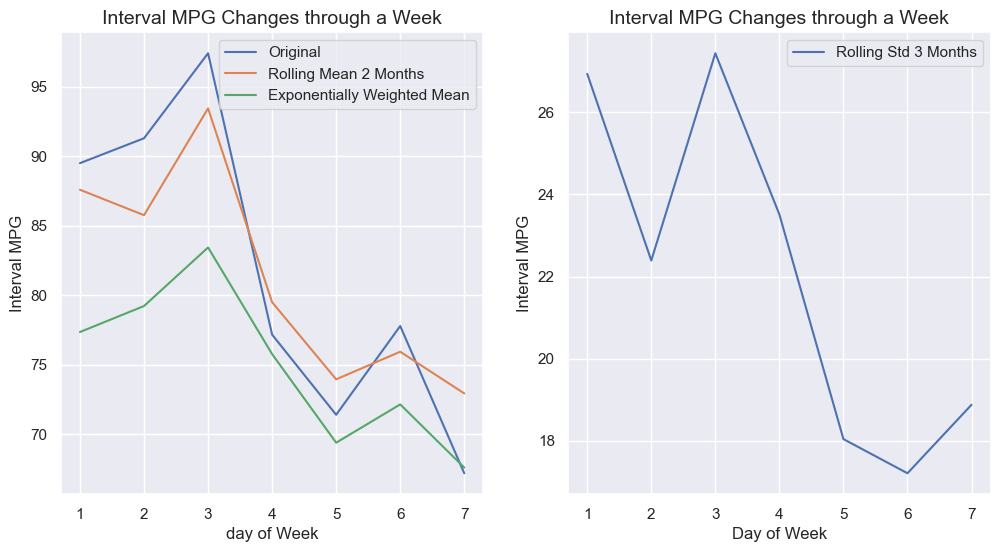

In [63]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_day_of_week = df2_by_day_of_week.sort("day_of_week")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["avg_interval_MPG"], label="Original")
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["rol_avg_int_mpg_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["int_mpg_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval MPG Changes through a Week", fontsize = 14)
ax1.set_xlabel("day of Week", fontsize = 12)
ax1.set_ylabel("Interval MPG", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["int_mpg_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval MPG Changes through a Week", fontsize = 14)
ax2.set_xlabel("Day of Week", fontsize = 12)
ax2.set_ylabel("Interval MPG", fontsize = 12)
ax2.legend()

# Paired t-test

In [64]:
# We now know that the computer generated interval mpg is always overestimated.
ttest_rel(df2["interval_MPG"], df2["interval_MPG_hand_calculated"], alternative="greater")

TtestResult(statistic=20.481312882381733, pvalue=7.355754594146598e-38, df=100)

# Data Split

In [ ]:
# data split
train = df2.filter(pl.col("Year") < 2023).clone()
test = df2.filter(pl.col("Year") >= 2023).clone()

# Linear Regression Model
https://tinyurl.com/2ysx6lxg

In [ ]:
train.select(['interval_days', 'overall_miles_lag', "interval_miles", "interval_gallons_lag", "interval_miles_lag", "Year", "Month", "day_of_week"]).head()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def run_linear_regression(train, test):
    lr = LinearRegression()
    random.seed(49)

    X_train = train.select(pl.col("overall_miles_lag"), pl.col("interval_gallons_lag"), pl.col("interval_miles_lag"), pl.col("Year"), pl.col("Month"), pl.col("day_of_week")).to_numpy()
    y_train = train.select("interval_miles")
    X_test = test.select(pl.col("overall_miles_lag"), pl.col("interval_gallons_lag"), pl.col("interval_miles_lag"), pl.col("Year"), pl.col("Month"), pl.col("day_of_week")).to_numpy()
    y_test = test.select("interval_miles")

    lr.fit(X_train, y_train)
    print('coefficient = ', lr.coef_[0])
    print('intercept = ', lr.intercept_)

    y_pred = lr.predict(X_test)
    plt.scatter(y_pred, y_pred - y_test, color = '#1f77b4')
    plt.hlines(y = 0, xmin = -10, xmax = 600, color = '#d62728')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()

    def measure_rmse(y_true, y_pred):
        return sqrt(mean_squared_error(y_true,y_pred))

    y_train_pred = lr.predict(X_train)
    rmse_train = measure_rmse(y_train, y_train_pred)
    rmse_test = measure_rmse(y_pred, y_test)

    # RMSE 
    print(f'The RMSE of the train that we will try to diminish is {round(rmse_train,4)}')
    print(f'The RMSE of the test is {round(rmse_test,4)}')

    # R^2
    print('r^2 train data: ', r2_score(y_train, y_train_pred))
    print('r^2 test data: ', r2_score(y_test, y_pred))

In [ ]:
run_linear_regression(train, test)

Exclue the data in 2020 because there were pandemic and the data is not reliable.

In [ ]:
df3 = df2.filter(pl.col("Year") != 2020)
# data split
train = df3.filter(pl.col("Year") < 2023).clone()
# val = df2[-60:-12].clone()
test = df3.filter(pl.col("Year") >= 2023).clone()
run_linear_regression(train, test)

Transform the response variable `interval_mileage` to log scale to make the data more normal.

# ARIMA model

### Check Stationarity
Before proceeding with the ARIMA model or any Time Series Models, we will check the stationarity of the series and apply the necessary transformations to achieve stationarity.
Unfortunatelly, I can't find compatibile `statsmodels` library for Polars dataframe. So I convert the dataframe to pandas dataframe and then use acf and pacf functions to check the stationarity of the series.

In [ ]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the df
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title("New York Temperature Variation in 1990-2012")
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.histplot(y, bins=int(sqrt(len(y))), ax=ax4)
    # sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

In [ ]:
# The first approach is to check the series without any transformation
# convert the Polars to Pandas
# set the index to the "date" column
# resample to a monthly frequency, using backward filling
# tmp = train.to_pandas().set_index("Date").asfreq('M', method='bfill')["interval_gallons"]
tmp = train.to_pandas().groupby("Date").mean().asfreq('M', method='bfill')["interval_gallons"]

check_stationarity(tmp)

In [ ]:
# https://tinyurl.com/255aa9fz
# https://tinyurl.com/2ao94khk``

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

tscv = TimeSeriesSplit(n_splits = 4)
rmse = []
for train_index, test_index in tscv.split(df2):
    cv_train, cv_test = df2[:train_index], df2[train_index:test_index]
    
    arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
    predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
print("RMSE: {}".format(np.mean(rmse)))
